<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Learning
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Introduction to Machine Learning
<br>
</font>
<font size=5>
Instructor: Dr. M. Bejani
<br>
</font>
<font size=4>
Spring 2025
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: TBD
</font>
<hr>
<font color='red'  size=4>
Note: It is highly recommended to run your notebook on Google Colab or Kaggle
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @yasinsala
</font>
<br>
<hr>
</div></font>

In this part we are going to use Restricterd Boltzman Machine(RBM) in practice, So we first impliment the class of RBM and then load the MNIST datset witch is very famous dataset and mainly used for education purposes and then train the RBM model on it

In [4]:
Name = "Seyyed Amirmahdi Sadrzadeh"
StudentId = "401102015"

In [3]:
# Here we need to import the libraries that we are going to use
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# define RBM class
here base on what you had learned in the class, impliment the RBM class, then we are going to instanciate this class for the training.


In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows:

$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$


In [5]:
class RBM(nn.Module):
    r"""Restricted Boltzmann Machine class.

    Args:
        n_vis (int, optional): The size of visible layer.
        the value of this parameter deponds on the shape of your dataset(here MNIST dataset)

        n_hid (int, optional): The size of hidden layer.
        the value of this parameter can be what ever you desire(should be less than n_vis)

        k (int, optional): The number of Gibbs sampling. Defaults to 1(for simplicity).
    """

    def __init__(self, n_vis, n_hid, k=1):
        """Create a RBM."""
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.zeros(n_vis))
        self.h = nn.Parameter(torch.zeros(n_hid))
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.01)
        self.k = k

    def visible_to_hidden(self, v):
        r"""
        Args:
            v (Tensor): The visible variable.

        Returns:
            Tensor: The hidden variable.
        """

        p = torch.sigmoid(F.linear(v, self.W.t(), self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        r"""
        Args:
            h (Tendor): The hidden variable.

        Returns:
            Tensor: The visible variable.
        """
        p = torch.sigmoid(F.linear(h, self.W, self.v))
        return p.bernoulli()

    def free_energy(self, v):
        r"""
        Args:
            v (Tensor): The visible variable.

        Returns:
            FloatTensor: The free energy value.

        """
        v_term = torch.matmul(v, self.v)
        h_term = torch.sum(torch.log1p(torch.exp(F.linear(v, self.W.t(), self.h) )), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        r"""
        Args:
            v (Tensor): The visible variable.

        Returns:
            (Tensor, Tensor): The real and generagted variables.
        """

        #TODO
        v_gibb = v
        # Performing k-step Contrastive Divergence
        for _ in range(self.k):
            h = self.visible_to_hidden(v_gibb)
            v_gibb = self.hidden_to_visible(h)
        return v, v_gibb

now that we impliment the RBM class, we need to train it, to do so impliment the following function for the training

In [6]:
def train(model, train_loader, n_epochs=20, lr=0.01):
    r"""
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.

    Returns:
        The trained model.

    """
    # define the optimizer. you can use Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = []
        for _, (data, target) in enumerate(train_loader):
            v, v_gibbs = model(data.view(-1, 784))
            # calculate loss and append it "loss" list in order to observe training
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            epoch_loss.append(loss.item())

            # optimize the model base on the loss
            # TODO
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(epoch_loss)))

    return model

In [21]:
# in order to show the generated images, use following function
def show_and_save(img, file_name):
    r"""
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    np_img = np.transpose(img.numpy(), (1, 2, 0))
    f = "%s.png" % file_name
    plt.imshow(np_img, cmap='gray')
    plt.imsave(f, np_img)

In [8]:
# for the training, we need to set some hyperparameters value,
# choose whatever you want, in order to get a solid results
batch_size = 64 # you can change this but for better display, do not
n_epochs = 10
lr = 0.01
n_hid = 256
n_vis = 784 # This value should match the dataset sahpe

In [9]:
# create a RBM model
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)

In [10]:
# now we crete the model, we need a dataset,
# so load MNIST dataset here using "torch.utils.data.DataLoader"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.bernoulli(x))  # Binarize immediately
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 462kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.71MB/s]


In [11]:
# now train the model
model = train(model, train_loader, n_epochs=n_epochs, lr=lr)

Epoch 0	 Loss=-5.2972
Epoch 1	 Loss=0.9303
Epoch 2	 Loss=3.3749
Epoch 3	 Loss=4.2617
Epoch 4	 Loss=4.6937
Epoch 5	 Loss=4.9010
Epoch 6	 Loss=5.0124
Epoch 7	 Loss=5.1460
Epoch 8	 Loss=5.1433
Epoch 9	 Loss=5.1167


here for showing how the model works, load images from "train_loader" and then feed it to the model, show real images and generated images

In [12]:
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images.view(-1, 784).bernoulli()
v, v_gibbs = model(images)

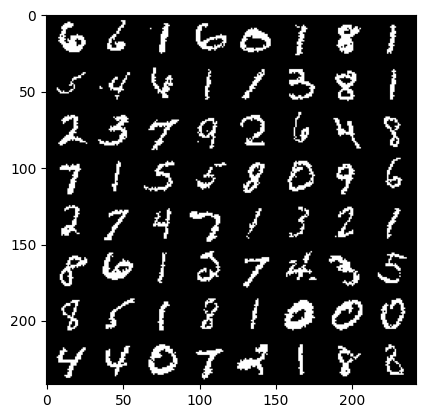

In [23]:
#show the real images
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'drive/MyDrive/Deep/HW1/RBM_Results/real')

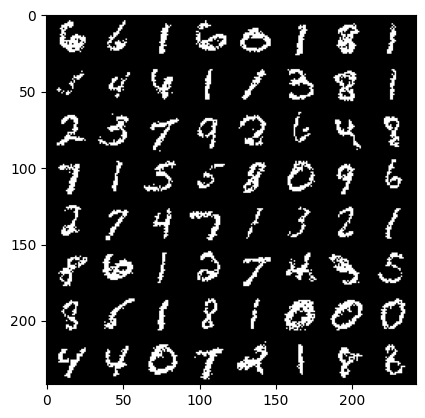

In [24]:
# show the generated images
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'drive/MyDrive/Deep/HW1/RBM_Results/fake')